In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
from scipy.stats import zscore


In [15]:
!pip install tensorly
import tensorly as tl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 94.4 MB/s eta 0:00:00


In [2]:
!pip install mne
import mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 113.0 MB/s eta 0:00:00


In [3]:
# Import google drive mounting module
from google.colab import drive

# Import os/path lib to navigate the colab directory.
import os
import pathlib


# Mount Google Drive at the default location
drive.mount('/content/drive', force_remount=False)
# Define the path to your desired folder
path = '/content/drive/My Drive/OPM-MEG'
# Change to that directory
os.chdir(path)
# Verify the current working directory
print("Current Directory:", os.getcwd())

Mounted at /content/drive
Current Directory: /content/drive/My Drive/OPM-MEG


In [4]:
!git clone https://github.com/hug0-w/Tensor-Decompositions-OPM-MEG/


fatal: destination path 'Tensor-Decompositions-OPM-MEG' already exists and is not an empty directory.


In [19]:
mat_path = "choice_pow_trial_chan_fbin_time_ds500_tpos.mat"

with h5py.File(mat_path, "r") as f:

    # --- main data ---
    # HDF5 reads MATLAB v7.3 arrays with transposed dimensions.
    # MATLAB Saved: [Trials, Chan, Freqs, Time]
    # Python Reads: (Time, Freqs, Chan, Trials)
    Pow = np.array(f["Pow"])

    freq = np.array(f["freq"]).squeeze()
    time = np.array(f["time"]).squeeze()

    freqs_hz = np.array(f["freqs_hz"]).squeeze()

    ds_fs = float(np.array(f["ds_fs"]).squeeze())
    fs_orig = float(np.array(f["fs_orig"]).squeeze())

    # --- channel labels (MATLAB cellstr) ---
    # MATLAB cell arrays of strings are stored as object references in HDF5
    ch_names_refs = f["chan_lbl"][()]
    chan_lbl = []
    for r in ch_names_refs.flatten():
        s = f[r][()]
        # MATLAB v7.3 stores strings as uint16 (utf-16le)
        chan_lbl.append(s.tobytes().decode("utf-16le").rstrip("\x00"))

    # --- MNE metadata ---
    mne_grp = f["mne"]

    ch_names_refs = mne_grp["ch_names"][()]
    mne_ch_names = []
    for r in ch_names_refs.flatten():
        s = f[r][()]
        mne_ch_names.append(s.tobytes().decode("utf-16le").rstrip("\x00"))

    ch_pos_m = np.array(mne_grp["ch_pos_m"], dtype=float)
    # MATLAB stored (N, 3), HDF5 reads (3, N). Transpose to get (N_chan, 3).
    if ch_pos_m.shape[0] == 3 and ch_pos_m.shape[1] != 3:
        ch_pos_m = ch_pos_m.T

    # Decode coordinate frame string (e.g., 'head')
    coord_frame_data = mne_grp["coord_frame"][()]
    try:
        coord_frame = coord_frame_data.tobytes().decode("utf-16le").rstrip("\x00")
    except AttributeError:
        # Fallback if it loaded as a simple byte string or char
        coord_frame = str(coord_frame_data)

In [8]:
data.shape

(121,)

In [9]:
pos = ch_pos_m
names = chan_lbl

n_chans = len(names)

In [10]:
info = mne.create_info(ch_names=names, sfreq=1000, ch_types='mag')

In [11]:
montage = mne.channels.make_dig_montage(
    ch_pos=dict(zip(names, pos)),
    coord_frame='head'
)

In [13]:
pos_2d = pos[:, :2]

In [55]:
pos_2d_jittered = pos_2d + np.random.normal(0, 0.0001, pos_2d.shape)

/usr/local/lib/python3.12/dist-packages/mne/viz/topomap.py:778: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]


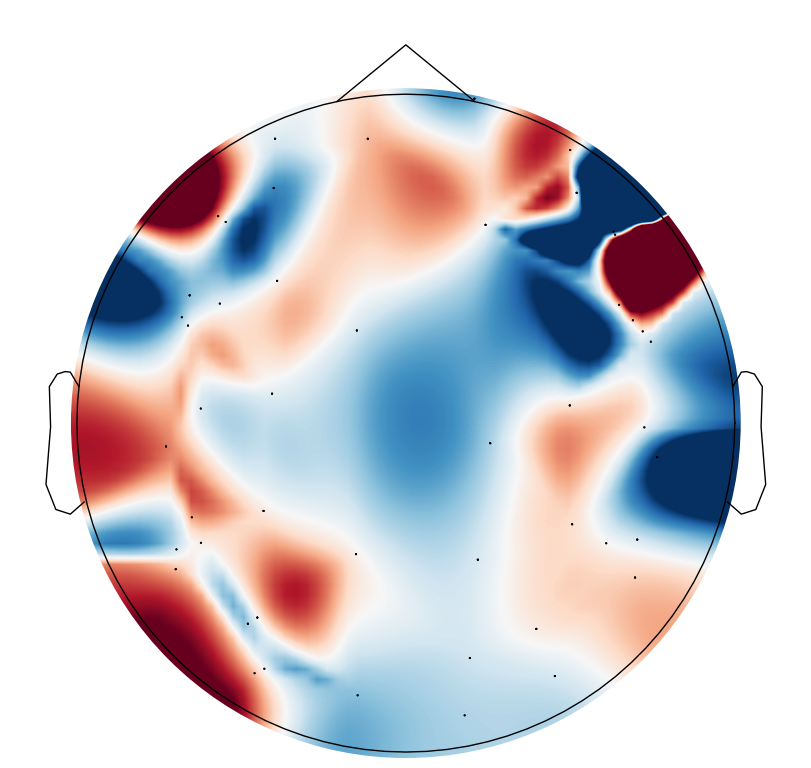

(<matplotlib.image.AxesImage at 0x78f795300920>, None)

In [14]:
mne.viz.plot_topomap(s,pos_2d,show=True,contours=0,size=8,sphere=0.12)

In [22]:
pow_T = Pow.T
log_Pow = np.log1p(pow_T)

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
log_Pow_torch = torch.as_tensor(log_Pow, device=device, dtype=torch.float32)

In [46]:
log_Pow_torch.shape[0]

195

In [16]:
from tensorly.decomposition import non_negative_parafac_hals

In [24]:
tl.set_backend('pytorch')
torch.set_default_dtype(torch.float32)

In [206]:
cp_tensor = non_negative_parafac_hals(
                log_Pow_torch,
                rank=10,
                init="random",
                n_iter_max=3000,
                tol=1e-9
            )

In [140]:
def plot_factors(A, B, C, D):
    """
    Plots the factor matrices A, B, C, and D without subplots,
    each component in a separate figure.

    Parameters
    ----------
    A : np.ndarray
        Factor matrix for mode 0 (e.g., trials).
    B : np.ndarray
        Factor matrix for mode 1 (e.g., channels).
    C : np.ndarray
        Factor matrix for mode 2 (e.g., frequencies).
    D : np.ndarray
        Factor matrix for mode 3 (e.g., time).
    """

    R = A.shape[1]

    for r in range(R):
        fig, axes = plt.subplots(1, 4, figsize=(18, 4))
        fig.suptitle(f'Component {r+1}', fontsize=16)

        # Mode 0 (trials)
        axes[0].bar(range(A.shape[0]), A[:, r], color='tab:blue')
        axes[0].bar(range(A.shape[0]), win_vector*A[:, r], color='tab:red')
        axes[0].set_title('Trials')
        axes[0].set_ylabel('Amplitude')
        axes[0].set_xlabel('Trial Number')

        # Mode 1 (channels)
        #axes[1].plot(B[:, r], color='tab:orange', ls='', marker='o')
        #axes[1].set_title('Channels')
        #axes[1].set_ylabel('Amplitude')
        #axes[1].set_xlabel('Channel')

        im, cn = mne.viz.plot_topomap(B[:, r], pos_2d,
                     axes=axes[1],
                     show=False,
                     contours=5,
                     sphere=0.12,cmap='RdBu_r',extrapolate='auto')
        cb = fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

        # Mode 2 (freq)
        #axes[2].plot(C[:, r], color='tab:green', ls='', marker='')
        freq = np.linspace(0,70,len(C[:, r]))
        axes[2].bar(freq,C[:, r], color='tab:green',alpha=0.5)
        axes[2].set_title('Frequency')
        axes[2].set_ylabel('Amplitude')
        axes[2].set_xlabel('Frequency (Hz)')

        # Mode 3 (time)
        time = np.linspace(0,1500,len(D[:, r]))
        axes[3].plot(time,D[:, r])
        axes[3].set_title('Time')
        axes[3].set_ylabel('Amplitude')
        axes[3].set_xlabel('Time (s)')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])


In [31]:
from tensorly.cp_tensor import cp_normalize


In [201]:
cp_tensor_norm = cp_normalize(cp_tensor)

In [202]:
weights, factors = cp_tensor_norm

In [203]:
factors = [f.to('cpu').numpy() for f in factors]
weights = weights.to('cpu').numpy()

In [204]:
A,B,C,D = factors

In [147]:
weights

array([30128.47 , 21020.58 , 34078.797, 14746.873, 19182.947, 36785.605,
       25384.951, 26441.322, 27315.518, 23502.295, 21022.496, 18016.38 ,
       39266.26 , 27522.51 , 23325.395], dtype=float32)

In [198]:
%cd ..
win_vector = np.loadtxt('win-vector.csv',unpack=True)

/content/drive/MyDrive/OPM-MEG


/usr/local/lib/python3.12/dist-packages/mne/viz/topomap.py:778: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]
/usr/local/lib/python3.12/dist-packages/mne/viz/topomap.py:778: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]
/usr/local/lib/python3.12/dist-packages/mne/viz/topomap.py:778: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]
/usr/local/lib/python3.12/dist-packages/mne/viz/topomap.py:778: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]
/usr/local/lib/python3.12/dist-packages/mne/viz/topomap.py:778: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]
/usr/local/lib/python3.12/dist-packages/mne/viz/topomap.py:778: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]
/usr/local/lib/python3.12/dist-packages/mne/viz/topomap.py:778: RuntimeWarning: in

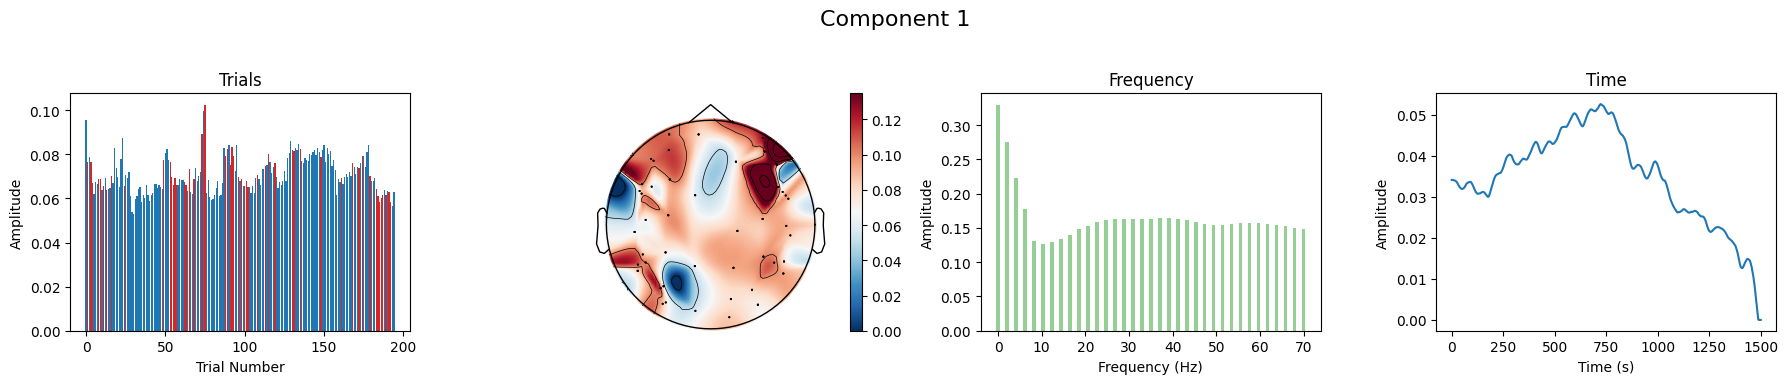

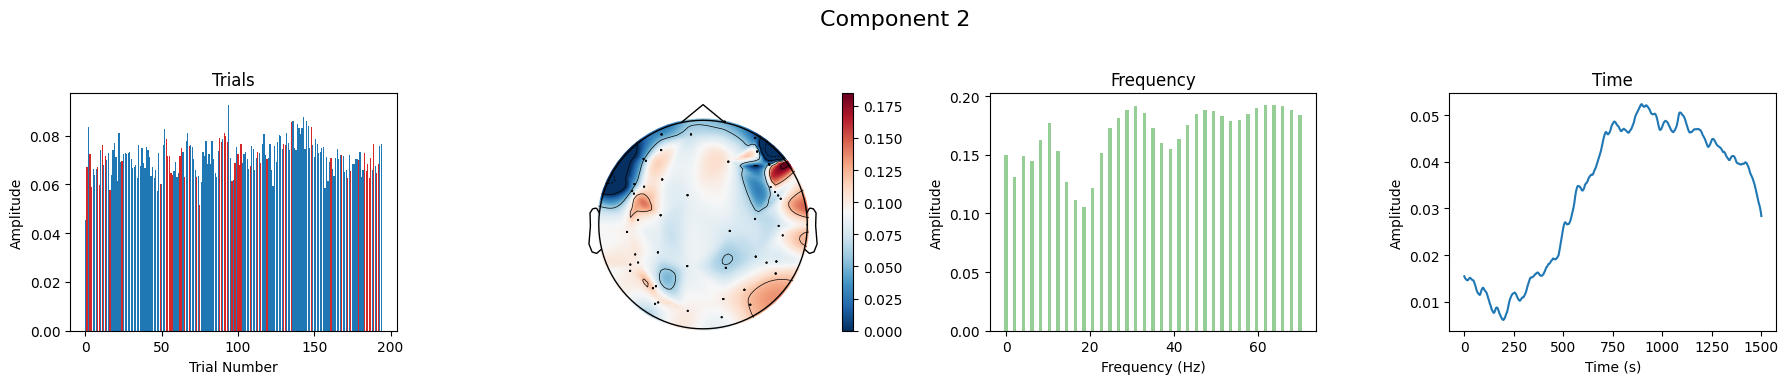

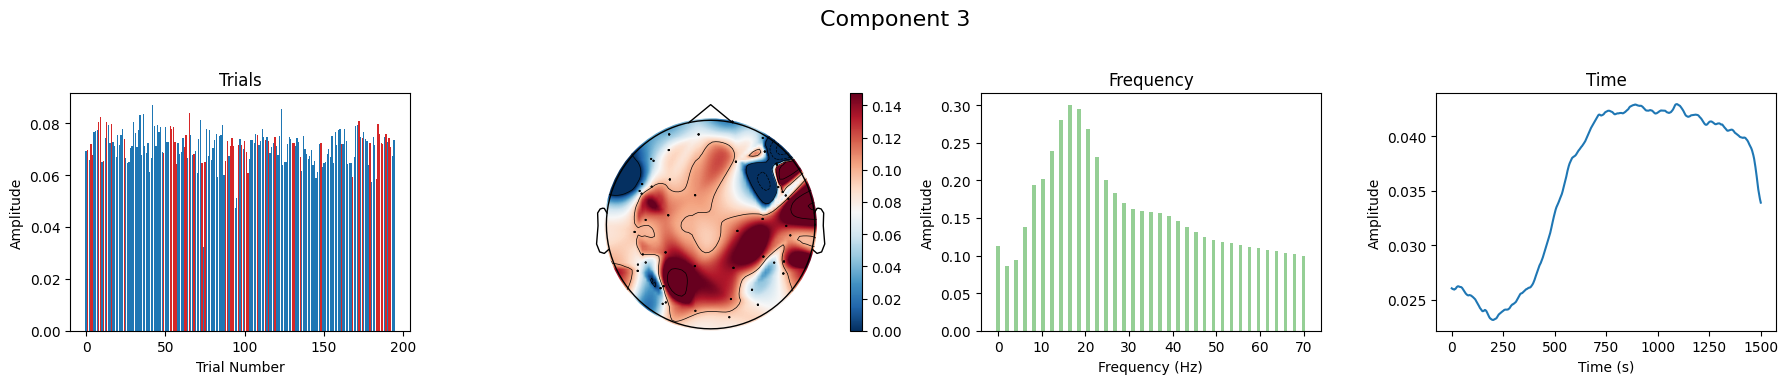

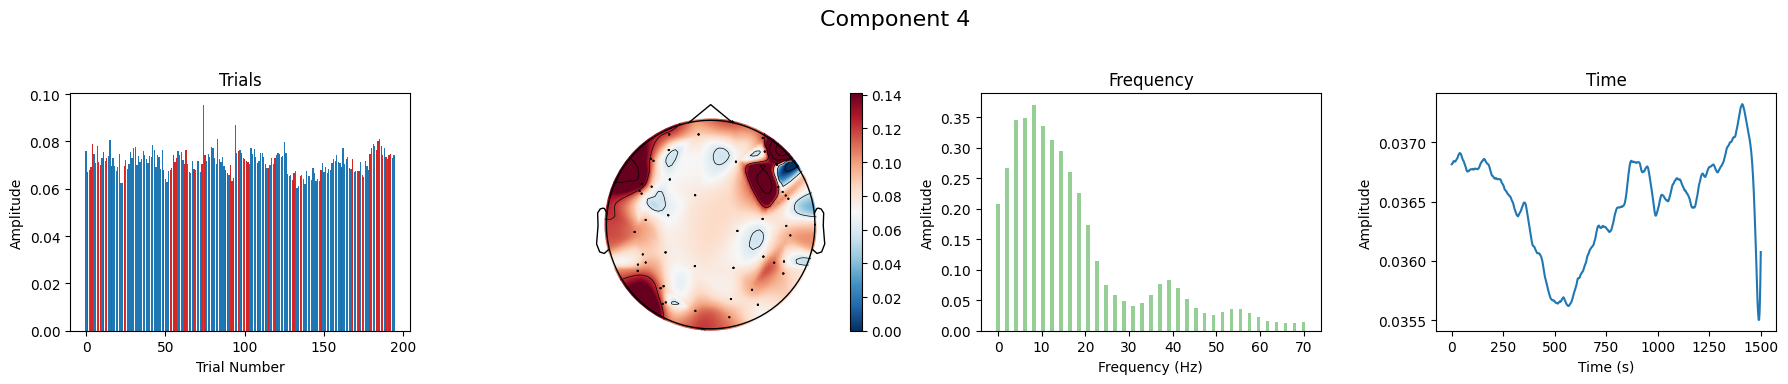

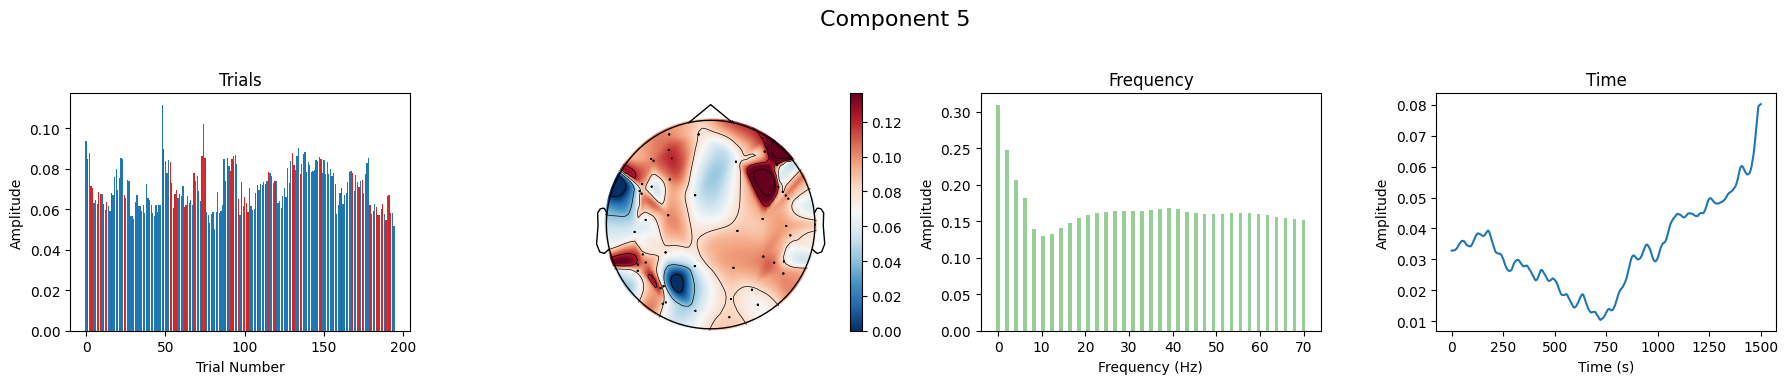

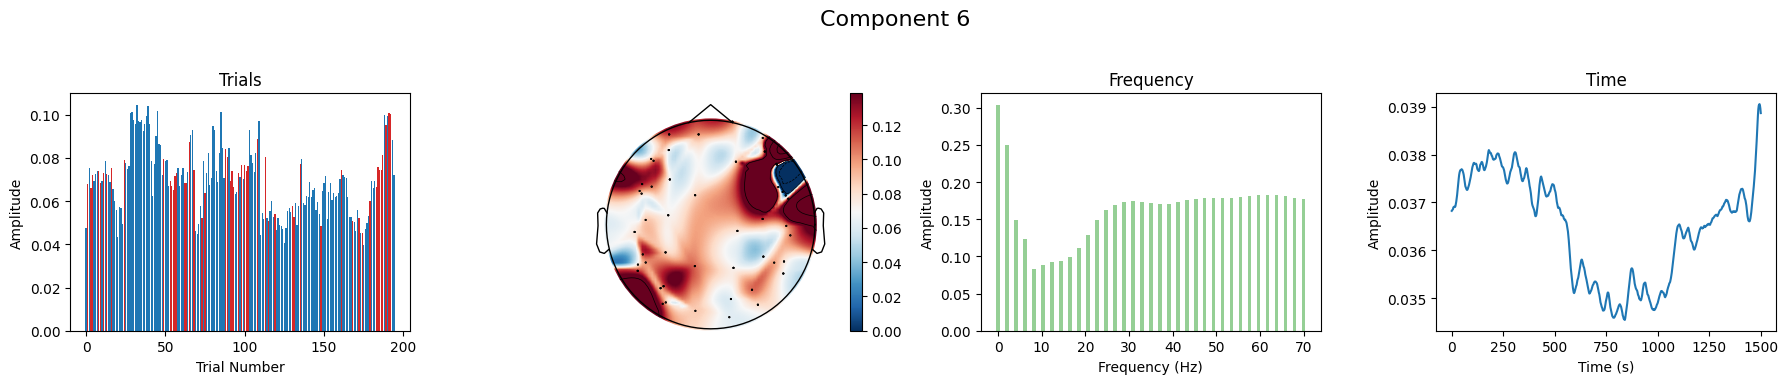

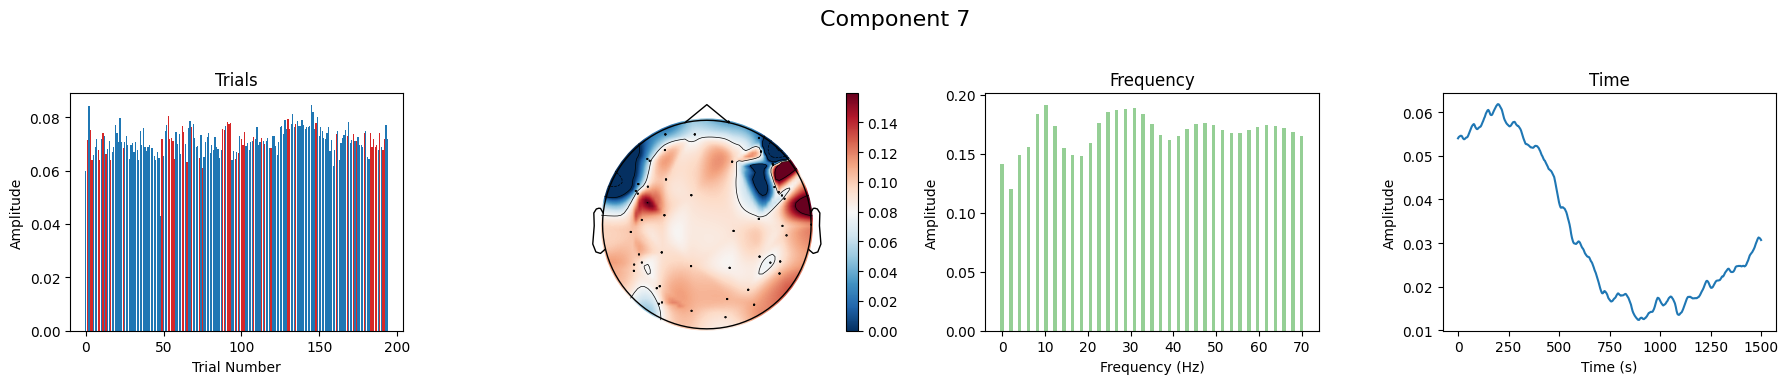

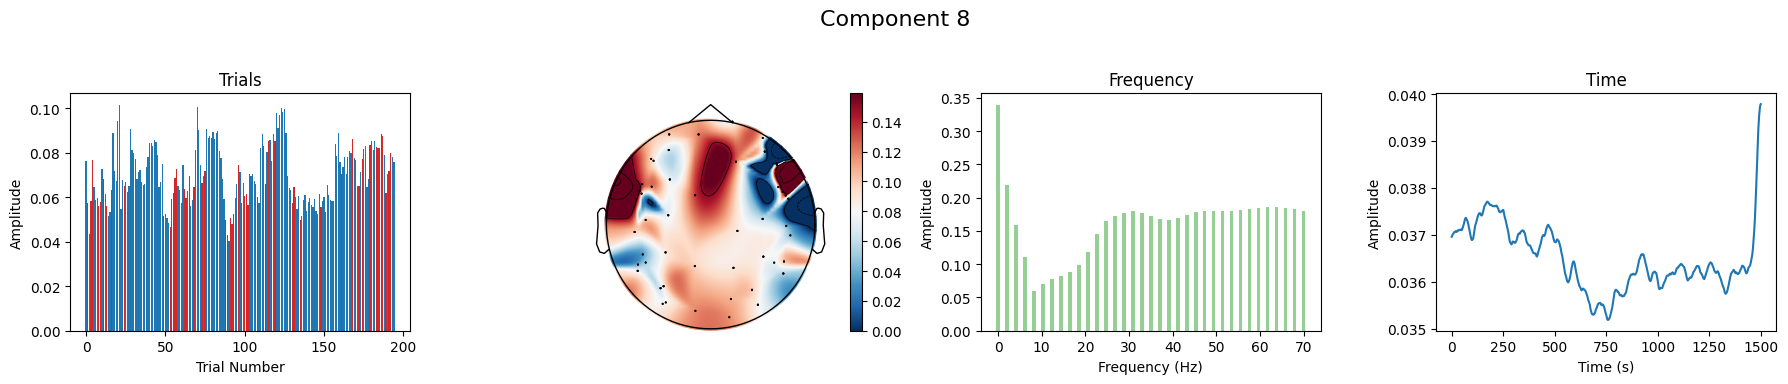

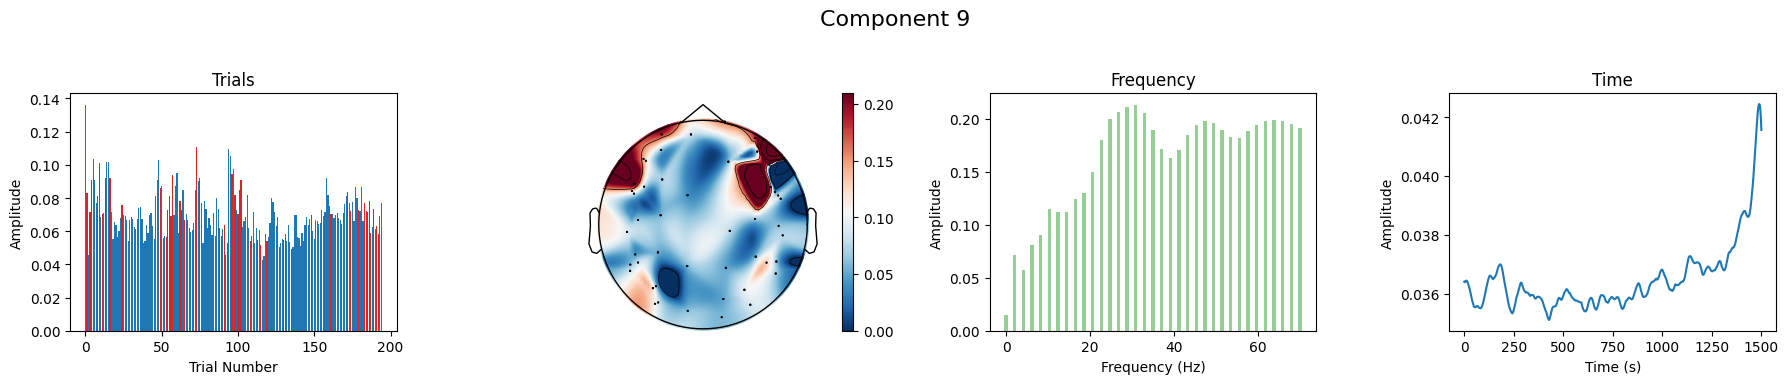

In [205]:
plot_factors(A,B,C,D)

In [152]:
from tensorly.cp_tensor import CPTensor

In [154]:
X = tl.cp_to_tensor(cp_tensor, mask=None)

In [180]:
%cd Tensor-Decompositions-OPM-MEG/
from src.tools.rankselection import  rel_error

[Errno 2] No such file or directory: 'Tensor-Decompositions-OPM-MEG/'
/content/drive/MyDrive/OPM-MEG/Tensor-Decompositions-OPM-MEG


In [181]:
relative_error = rel_error(log_Pow_torch, cp_tensor)

In [182]:
print(relative_error)

tensor(0.1009, device='cuda:0')


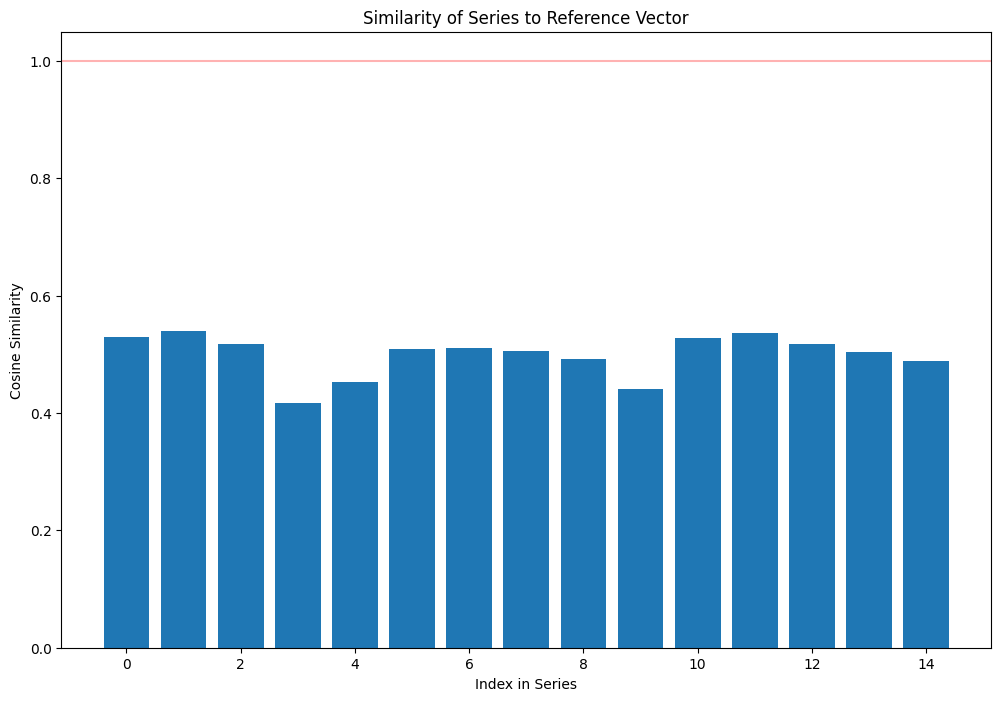

In [190]:
ref_vector = win_vector
series = A.T

def calculate_cosine_similarity(v, m):
    # Dot product of ref_vector with every vector in the series
    dot_product = np.dot(m, v)
    # Norms (magnitudes)
    norm_v = np.linalg.norm(v)
    norm_m = np.linalg.norm(m, axis=1)
    return dot_product / (norm_v * norm_m)

similarities = calculate_cosine_similarity(ref_vector, series)


plt.figure(figsize=(12, 8))
plt.bar(range(len(similarities)),similarities, color='tab:blue')
plt.axhline(1, color='red', linestyle='-', alpha=0.3, label='Perfect Match')
plt.xlabel('Index in Series')
plt.ylabel('Cosine Similarity')
plt.title('Similarity of Series to Reference Vector')
plt.show()